In [1]:
import meanreversion as mr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

[*********************100%***********************]  1 of 1 completed


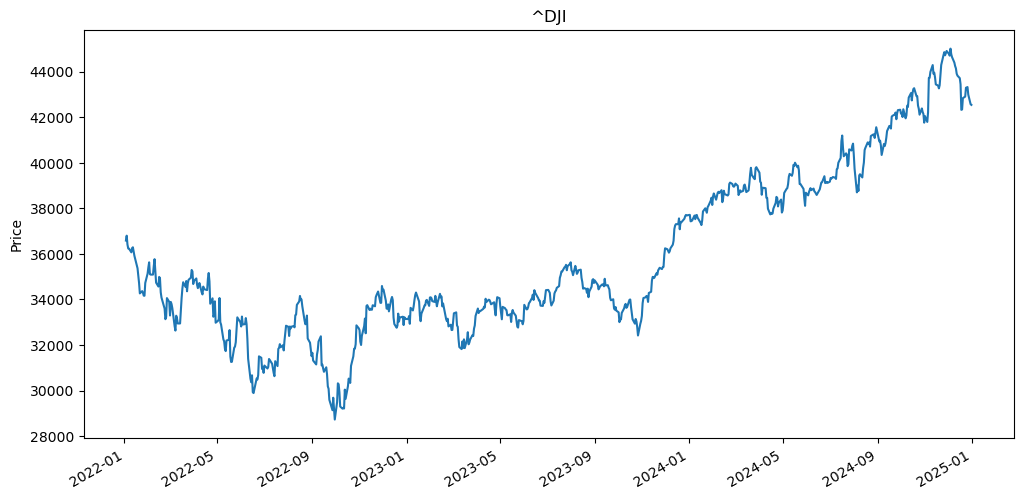

In [256]:
# Download data and plotting closing price

asset_name = "^DJI"
data = mr.download_asset(asset_name, start='2022-01-01',end='2025-01-01')
df = data.set_index("AbsTime")[["Close"]]
df = df.asfreq('B')
df = df.dropna()

df["rect"] = (df["Close"] - savgol_filter(df["Close"], 180, 3)) / df["Close"]   # Rectifying price using moving average

ax = df["Close"].plot(figsize=(12,6))
plt.title(asset_name)
plt.ylabel("Price")
plt.xlabel("")
plt.show()

In [326]:
# Utils functions updated for working with rolling/apply with pandas
# (same implementation as in meanreversion.py)

def find_period_fft(x : np.array) -> tuple:
    from scipy.fftpack import fft, fftfreq, ifft
    fourier = np.abs(fft(x))
    freqs = fftfreq(len(x))
    mask = np.where(freqs > 0)
    fourier = fourier[mask]
    freqs = freqs[mask]
    max_freq = np.mean(freqs[np.argsort(fourier)][-3:])
    return 1/max_freq

def find_zeros(x : np.array) -> np.array:
    t = np.arange(len(x))
    zeros = []
    for i in range(len(x)-1):
        if x[i]*x[i+1] < 0:
            zeros.append(t[i])
    return np.array(zeros, dtype=float)

def find_period(x : np.array) -> np.array:
    x = savgol_filter(x, len(x)//10, 3, mode='nearest')
    zeros = find_zeros(x)
    periods = []
    for i in range(len(zeros)-1):
        periods.append((zeros[i+1] - zeros[i])*2)
    period = np.mean(periods)
    return period

def find_amplitudes(x : np.array) -> np.array:
    from scipy.signal import find_peaks
    factor = 0.3
    dist = factor*len(x)*np.mean(find_period(x))/(len(x))
    max_peaks, _ = find_peaks(x, distance=dist, height=0.0)
    min_peaks, _ = find_peaks(-x, distance=dist, height=0.0)
    return np.mean(np.concatenate((x[max_peaks], -x[min_peaks])))

def volatility(x : pd.Series) -> float:
    from statsmodels.tsa.arima.model import ARIMA
    AR_model = ARIMA(x, order=(1,0,0), trend='n', enforce_stationarity=False)
    res = AR_model.fit(method='burg')
    AR_phi = res.arparams[0]
    AR_sigma = res.params[-1]

    dt = 1
    theta_AR = -np.log(AR_phi)/dt
    sigma_AR = np.sqrt(AR_sigma * (2 * theta_AR / (1 - AR_phi**2)))
    
    return sigma_AR


## Rolling amplitude 

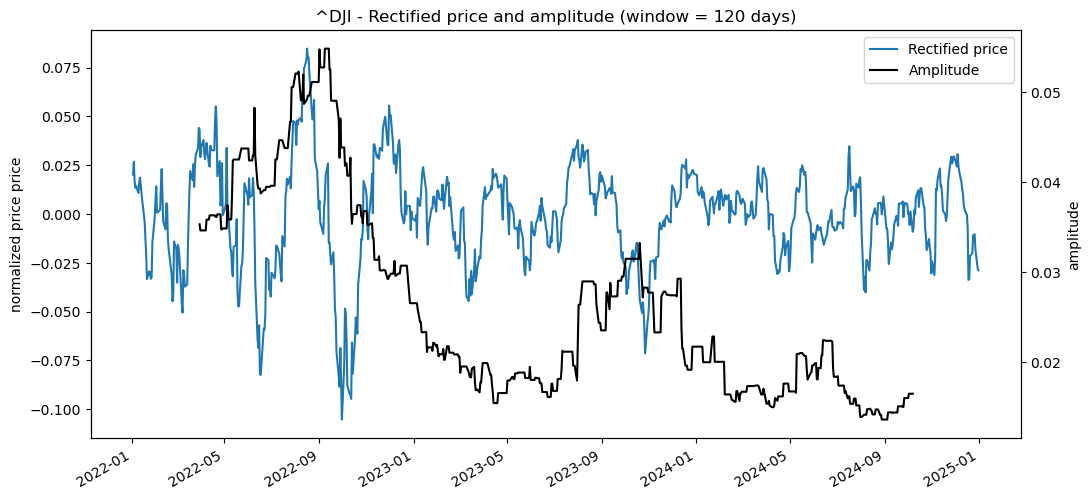

In [327]:
window = 120

df["amplitude"] = df["rect"].rolling(window=window, center=True).apply(find_amplitudes, raw=True)
#df["amplitude"] = df["rect"].rolling(window=window, center=False).std()   # alternative using standard deviation

def apply_savgol_with_nan(s, window_length, polyorder):
    s_filtered = s.copy()
    not_nan = s.notna()
    groups = (not_nan.astype(int).diff().fillna(0) != 0).cumsum()
    for _, group in s[not_nan].groupby(groups):
        if len(group) >= window_length:
            s_filtered[group.index] = savgol_filter(group.values, window_length, polyorder, mode="nearest")
    return s_filtered

# Optional smoothing
#df["amplitude"] = apply_savgol_with_nan(df["amplitude"], window, 3)

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["amplitude"].plot(ax=ax2, color='k', label="Amplitude")
ax.set_ylabel("rect")
ax2.set_ylabel("amplitude")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)
plt.title(f"{asset_name} - Rectified price and amplitude (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price price")
ax2.set_ylabel("amplitude")
plt.show()

## Rolling volatility

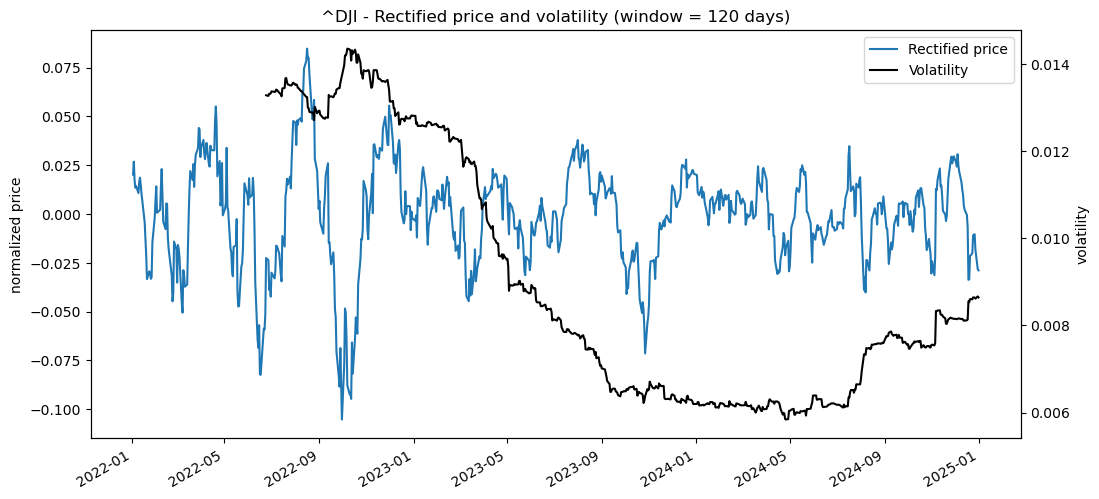

In [328]:
window = 120
df["volatility"] = df["rect"].rolling(window=window, center=False).apply(volatility, raw=True)
#df["volatility"] = apply_savgol_with_nan(df["volatility"], 60, 3)

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["volatility"].plot(ax=ax2, color='k', label="Volatility")
ax.set_ylabel("rect")
ax2.set_ylabel("volatility")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)
plt.title(f"{asset_name} - Rectified price and volatility (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price")
ax2.set_ylabel("volatility")
plt.show()

## Rolling mean reversion index

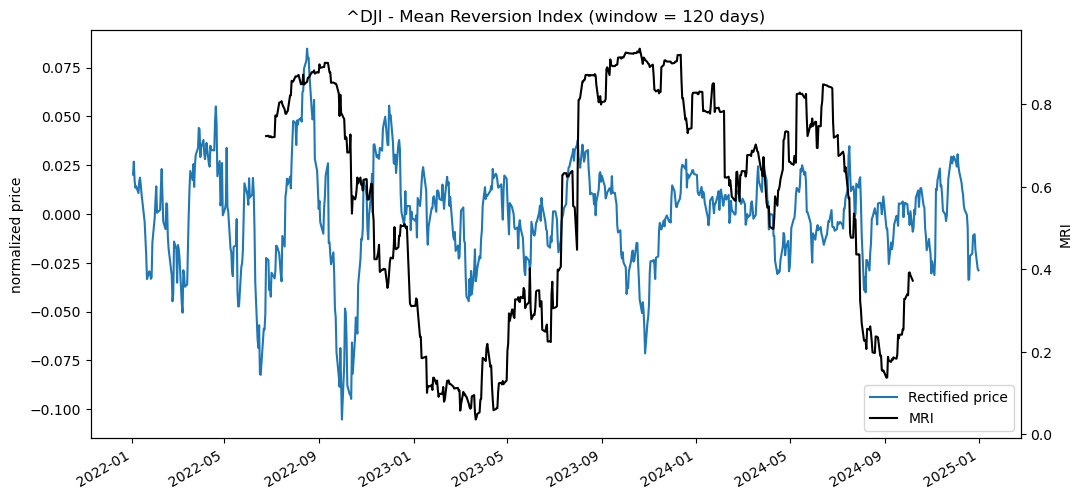

In [329]:
# normalization volatility-amplitude ratio using sigmoid function (parameter to be tuned)
#df["MRI"] = 1 / ( 1 + np.exp(150*df["volatility"]**2 / df["amplitude"]-3)) # alternative with sqared volatility (seems to work better)
df["MRI"] = 1 / ( 1 + np.exp(12*df["volatility"] / df["amplitude"]-5))
#df["MRI"] = apply_savgol_with_nan(df["MRI"], 90, 3) # smoothing

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["MRI"].plot(ax=ax2, color='k', label="MRI")
ax.set_ylabel("rect")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.title(f"{asset_name} - Mean Reversion Index (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price")
ax2.set_ylabel("MRI")
plt.show()

## Rolling mean reversion period

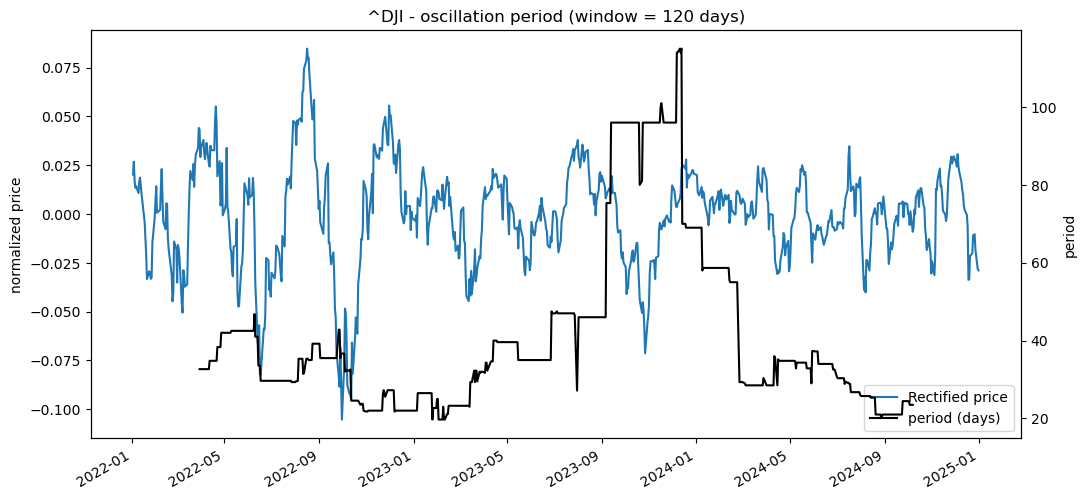

In [330]:
window = 120

df["period"] = df["rect"].rolling(window=window, center=True).apply(find_period, raw=True)
#df["period"] = apply_savgol_with_nan(df["period"], 180, 3)

ax = df["rect"].plot(figsize=(12,6), label="Rectified price")
ax2 = ax.twinx()
df["period"].plot(ax=ax2, color='k', label="period (days)")
ax.set_ylabel("rect")
ax2.set_ylabel("period")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.title(f"{asset_name} - oscillation period (window = {window} days)")
ax.set_xlabel("")
ax.set_ylabel("normalized price")
ax2.set_ylabel("period")
plt.show()